In [ ]:
!pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from obspy import read, UTCDateTime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta
from obspy.signal.filter import envelope
from scipy.stats import kurtosis, skew
from google.colab import drive
import tensorflow as tf
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_stream(filename, sampling_rate):
  stream = read(filename, debug_header=True)
  stream = stream.select(sampling_rate=sampling_rate)
  
  station = ""
  for trace in stream:
    if station == trace.stats.station:
      stream.remove(trace)
    station = trace.stats.station
  
  return stream

In [ ]:
path_rawData = "drive/MyDrive/data/training/raw_data"
files = os.listdir(path_rawData)
len(files)

260

In [ ]:
os.remove(path_rawData+'/'+files[33])

In [ ]:
def runningKurt(x, N):
    y = np.zeros((len(x) - (N - 1),))
    for i in range(len(x) - (N - 1)):
         y[i] = kurtosis(x[i:(i + N)])
    return y

def runningSkew(x, N):
    y = np.zeros((len(x) - (N - 1),))
    for i in range(len(x) - (N - 1)):
         y[i] = skew(x[i:(i + N)])
    return y

In [ ]:
def plot_stream(stream):
  plt.figure(figsize=(20,5))
  for i in range(len(stream)):
    plt.subplot(len(stream), 1, i + 1)
    plt.plot(stream[i], label=stream[i].stats.station, color='black')
    plt.legend()
  plt.show()

In [ ]:
def preprocess(stream, freq, corners):
  for i in range(len(stream)):
    stream[i] = stream[i].filter('lowpass', freq=freq, corners=corners, zerophase=True).normalize()
  return stream

In [ ]:
def make_parameters(stream, sta, lta, sampling_rate):
  traces_classic_sta_lta = classic_sta_lta(stream[0], int(sta*sampling_rate), int(lta*sampling_rate))
  traces_recursive_sta_lta = recursive_sta_lta(stream[0], int(sta*sampling_rate), int(lta*sampling_rate))
  traces_envelope = envelope(stream[0].data)
  traces_kurtosis = list(runningKurt(stream[0].data, 360)) 
  traces_kurtosis[:0] = [0 for i in range(len(traces_kurtosis), len(stream[0].data), 1)]
  traces_skewness = list(runningSkew(stream[0].data, 360))
  traces_skewness[:0] = [0 for i in range(len(traces_skewness), len(stream[0].data), 1)]

  return traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness

In [ ]:
def multiplot(stream, traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness, index_non_fb1, index_fb, index_non_fb2, index):
  plt.figure(figsize=(15,10))

  plt.subplot(6,1,1)
  plt.plot(stream[0].data, label='Trace ' + str(index+1), color='black')
  plt.axvline(x= index_fb, linewidth=1, color='red', label='first break')
  plt.axvline(x= index_non_fb1, linewidth=1, color='blue', label='non-first break')
  plt.axvline(x= index_non_fb2, linewidth=1, color='blue')
  plt.legend()

  plt.subplot(6,1,2)
  plt.plot(traces_classic_sta_lta, label='classic STA/LTA', color='black')
  plt.axvline(x= index_fb, linewidth=1, color='red', label='first break')
  plt.legend()

  plt.subplot(6,1,3)
  plt.plot(traces_recursive_sta_lta, label='recursive STA/LTA', color='black')
  plt.axvline(x= index_fb, linewidth=1, color='red', label='first break')
  plt.legend()

  plt.subplot(6,1,4)
  plt.plot(traces_envelope, label='envelope', color='black')
  plt.axvline(x= index_fb, linewidth=1, color='red', label='first break')
  plt.legend()

  plt.subplot(6,1,5)
  plt.plot(traces_kurtosis, label='kurtosis', color='black')
  plt.axvline(x= index_fb, linewidth=1, color='red', label='first break')
  plt.legend()

  plt.subplot(6,1,6)
  plt.plot(traces_skewness, label='skewness', color='black')
  plt.axvline(x= index_fb, linewidth=1, color='red', label='first break')
  plt.legend()

In [ ]:
def write_csv(traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness, path, index_stream, index_fb, mode, header):
  classic_sta_lta_value = []
  recursive_sta_lta_value = []
  envelope_value = []
  kurtosis_value = []
  skewness_value = []
  label = []

  for index in range(index_fb-50, index_fb+51, 1):
    classic_sta_lta_value.append(traces_classic_sta_lta[index])
    recursive_sta_lta_value.append(traces_recursive_sta_lta[index])
    envelope_value.append(traces_envelope[index])
    kurtosis_value.append(traces_kurtosis[index])
    skewness_value.append(traces_skewness[index])
    if index == index_fb:
      label.append(1)
    else:
      label.append(0)

  data = {'classic STA/LTA' : classic_sta_lta_value,
      'recursive STA/LTA' : recursive_sta_lta_value,
      'envelope' : envelope_value,
      'kurtosis' : kurtosis_value,
      'skewness' : skewness_value,
      'label' : label
      }

  df = pd.DataFrame(data)

  with open(path, mode, encoding='utf-8-sig') as f:
    df.to_csv(f, header=header, index=False)

In [ ]:
index_stream = 0
trace = files[index_stream]
stream = read(path_rawData+"/"+trace)

stream = preprocess(stream, 1, 3)

sta = 2
lta = 30

traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness = make_parameters(stream, sta, lta, 40)

print(np.argsort(traces_kurtosis)[::-1][:100])

[ 359  360  361  362 2383 2384 2385 2382 2386 2381 2387 2388 2380 2389
 2390 2379  363 2391 2392 2393 2378 2394 2395 2396 2397 2398 2377 2399
 2400 2401  364 2402 2403 2404 2405 2406 2376 2407 2408 2409 2410 2411
 2412 2413 2414 2415 2416 2375 2417 2418 2419 2420  365 2421 2422 2423
 2374 2424 2425 2426 2427 2428 2373 2429 2430  366 2431 2432 2433 2434
 2435 2372 2436 2437 2438 2439 2440 2441 2442 2443 2444 2445 2446 2447
 2449 2448 2450 2451 2452 2453 2454 2455 2456 2457 2458 2459 2460 2461
 2462 2463]


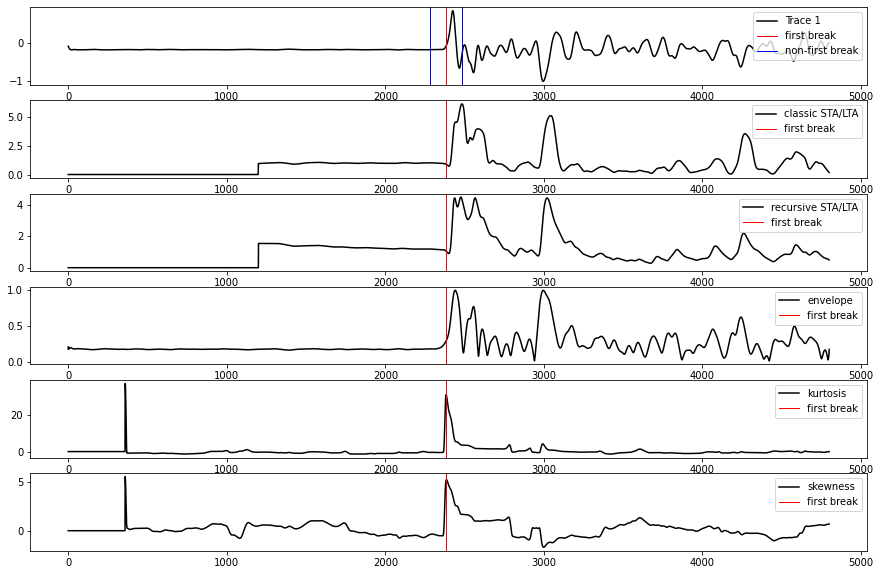

In [ ]:
index_fb = 2383                    # atur value hingga terdapat hubungan antara klasik, recursive, envelope, kurtosis, dan skewness

index_non_fb1 = index_fb - 100
index_non_fb2 = index_fb + 100

multiplot(stream, traces_classic_sta_lta, 
          traces_recursive_sta_lta, traces_envelope,
          traces_kurtosis, traces_skewness, 
          index_non_fb1, index_fb, index_non_fb2, index_stream)

In [ ]:
path_dataset = '/content/drive/MyDrive/data/training/dataset_training_kirikanan50.csv'
mode = 'a'
header = False

write_csv(traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness, path_dataset, index_stream, index_fb, mode, header)

In [ ]:
path = '/content/drive/MyDrive/data/training/dataset_training_kirikanan50.csv'
df = pd.read_csv(path)
df

,classic STA/LTA,recursive STA/LTA,envelope,kurtosis,skewness,label
0,0.993524,1.158187,0.188611,-0.527205,-0.508918,0
1,0.992716,1.157768,0.189158,-0.529218,-0.511307,0
2,0.991906,1.157358,0.189730,-0.531142,-0.513290,0
3,0.991095,1.156956,0.190326,-0.532920,-0.514885,0
4,0.990285,1.156562,0.190950,-0.534491,-0.516113,0
...,...,...,...,...,...,...
29790,14.464339,11.452636,0.563313,3.833336,-2.306676,0
29791,14.465699,11.350128,0.550304,3.724947,-2.281291,0
29792,14.466528,11.246202,0.537374,3.629318,-2.258195,0
29793,14.466963,11.141628,0.525109,3.543424,-2.236901,0


In [ ]:
X = df.iloc[:,:5]
Y = df.iloc[:,5]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) 

X_train = np.resize(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.resize(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', 
                                                       kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01), 
                                                       return_sequences=True), input_shape=(1, 5)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 128)           35840     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
652/652 [==============================] - 6s 5ms/step - loss: 1.6415 - accuracy: 0.9898 - val_loss: 0.9094 - val_accuracy: 0.9905
Epoch 2/50
652/652 [==============================] - 3s 4ms/step - loss: 0.4996 - accuracy: 0.9899 - val_loss: 0.1970 - val_accuracy: 0.9905
Epoch 3/50
652/652 [==============================] - 3s 4ms/step - loss: 0.1298 - accuracy: 0.9899 - val_loss: 0.0844 - val_accuracy: 0.9905
Epoch 4/50
652/652 [==============================] - 2s 4ms/step - loss: 0.0791 - accuracy: 0.9899 - val_loss: 0.0607 - val_accuracy: 0.9905
Epoch 5/50
652/652 [==============================] - 3s 4ms/step - loss: 0.0641 - accuracy: 0.9899 - val_loss: 0.0534 - val_accuracy: 0.9905
Epoch 6/50
652/652 [==============================] - 3s 4ms/step - loss: 0.0602 - accuracy: 0.9899 - val_loss: 0.0510 - val_accuracy: 0.9905
Epoch 7/50
652/652 [==============================] - 2s 4ms/step - loss: 0.0588 - accuracy: 0.9899 - val_loss: 0.0520 - val_accuracy: 0.9905
Epoch 

In [ ]:
'''
classic_sta_lta_value = []
recursive_sta_lta_value = []
envelope_value = []
kurtosis_value = []
skewness_value = []
label = []
'''

In [ ]:
'''
idx = pd.read_csv("/content/index_trigger1.txt", header=None, names=['index'])
index = idx['index']
for j in range(len(index)):
  stream = read(path_rawData+"/"+files[j])
  stream = preprocess(stream, 1, 3)
  traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope = make_parameters(stream, 2, 30, 40)

  kurt_t = list(runningKurt(stream[0].data, 360)) 
  kurt_t[:0] = [0 for i in range(len(kurt_t), len(stream[0].data), 1)]
  skew_t = list(runningSkew(stream[0].data, 360))
  skew_t[:0] = [0 for i in range(len(skew_t), len(stream[0].data), 1)]

  idx_tr = int(index[j][:4])

  for k in range(idx_tr-50, idx_tr+51, 1):
    classic_sta_lta_value.append(traces_classic_sta_lta[k])
    recursive_sta_lta_value.append(traces_recursive_sta_lta[k])
    envelope_value.append(traces_envelope[k])
    kurtosis_value.append(kurt_t[k])
    skewness_value.append(skew_t[k])
    if k == idx_tr:
      label.append(1)
    else:
      label.append(0)
'''

In [ ]:
'''
data1 = {'classic STA/LTA' : classic_sta_lta_value,
      'recursive STA/LTA' : recursive_sta_lta_value,
      'envelope' : envelope_value,
      'kurtosis' : kurtosis_value,
      'skewness' : skewness_value,
      'label' : label
      }

df1 = pd.DataFrame(data1)
'''

In [ ]:
with open('/content/drive/MyDrive/data/training/dataset_training_kirikanan50.csv', 
          'a', encoding='utf-8-sig') as f:
  df1.to_csv(f, header=True, index=False)

In [ ]:
df1

,classic STA/LTA,recursive STA/LTA,envelope,kurtosis,skewness,label
0,0.993524,1.158187,0.188611,-0.527205,-0.508918,0
1,0.992716,1.157768,0.189158,-0.529218,-0.511307,0
2,0.991906,1.157358,0.189730,-0.531142,-0.513290,0
3,0.991095,1.156956,0.190326,-0.532920,-0.514885,0
4,0.990285,1.156562,0.190950,-0.534491,-0.516113,0
...,...,...,...,...,...,...
29790,14.464339,11.452636,0.563313,3.833336,-2.306676,0
29791,14.465699,11.350128,0.550304,3.724947,-2.281291,0
29792,14.466528,11.246202,0.537374,3.629318,-2.258195,0
29793,14.466963,11.141628,0.525109,3.543424,-2.236901,0


In [ ]:
model.evaluate(X_test, y_test)

280/280 [==============================] - 0s 2ms/step - loss: 0.0486 - accuracy: 0.9905


[0.04860491678118706, 0.9904910922050476]

In [ ]:
import pickle

In [ ]:
pickle.dump(model, open("train_model.pkl", 'wb'))

In [ ]:
model.save("/content/model_lstm.h5")

In [ ]:
savedModel = tf.keras.models.load_model("/content/model_lstm.h5")
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 128)           35840     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9

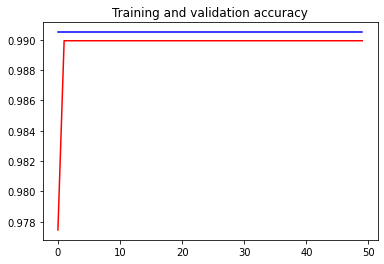

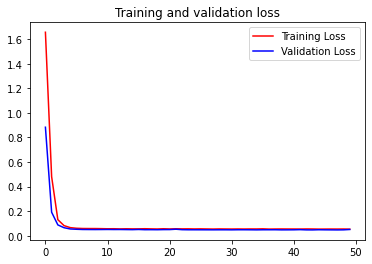

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1 Trace(s) in Stream:
IU.DAV.00.BHZ | 2017-12-15T16:51:52.044538Z - 2017-12-15T16:53:52.019538Z | 40.0 Hz, 4800 samples


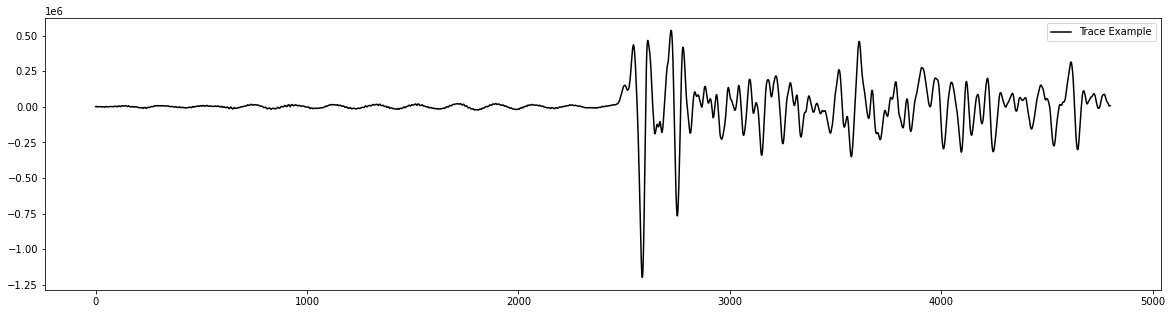

In [ ]:
files = os.listdir("/content/drive/MyDrive/data/testing")

trace_example = read("/content/drive/MyDrive/data/testing/" + files[0])
print(trace_example)
plt.figure(figsize=(20,5))
plt.plot(trace_example[0], label='Trace Example', color='black')
plt.legend()
plt.show()

150/150 [==============================] - 1s 2ms/step

Predict to First Break wave-P!



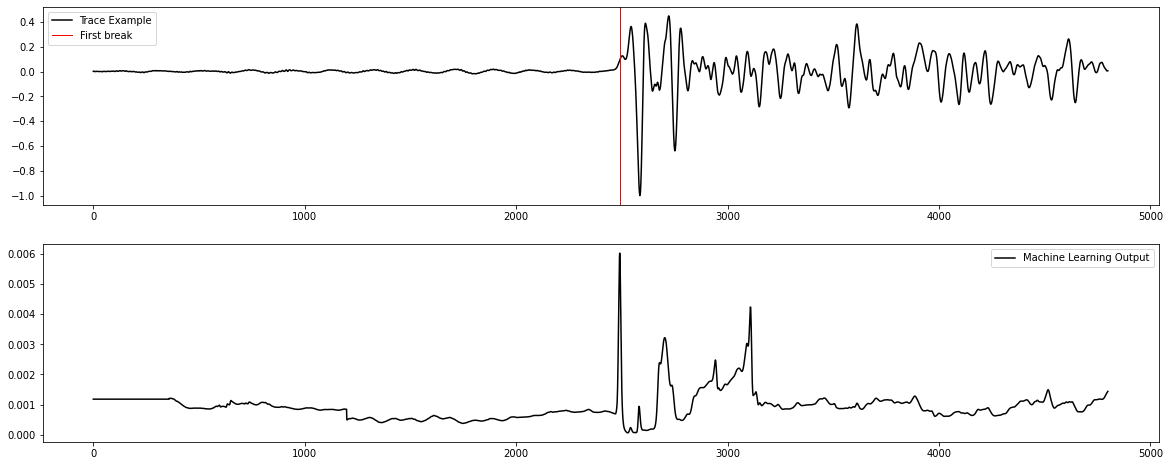

In [ ]:
trace_example.normalize()
traces_classic_sta_lta, traces_recursive_sta_lta, traces_envelope, traces_kurtosis, traces_skewness = make_parameters(trace_example, 2, 30, 40)

data_example = {'classic STA/LTA' : traces_classic_sta_lta,
                'recursive STA/LTA' : traces_recursive_sta_lta,
                'envelope' : traces_envelope,
                'kurtosis' : traces_kurtosis,
                'skewness' : traces_skewness
                 }

df_example = pd.DataFrame(data_example)
df_example = np.resize(df_example, (df_example.shape[0], 1, df_example.shape[1]))

predict = savedModel.predict(df_example)
predict = np.resize(predict, (predict.shape[1], predict.shape[0]))
idx_predict = predict[0].argmax()

print()
print("Predict to First Break wave-P!")
print()

plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(trace_example[0], label='Trace Example', color='black')
plt.axvline(x= idx_predict, linewidth=1, color='red', label='First break')
plt.legend()
plt.subplot(2,1,2)
plt.plot(predict[0], label='Machine Learning Output', color='black')
plt.legend()
plt.show()

In [ ]:
import pickle as pkl
import sklearn

In [ ]:
pkl.dump(model, open("final_model.p", "wb"))